In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

: 

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import numpy as np
import h5py

import json
import pickle

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device {device}")


torch.manual_seed(0)


device cuda


In [5]:
def encode_one_hot(input_label : torch.tensor):
    """
    expect tensor with two values 
    """
    if input_label == 0:
        return torch.tensor([1,0], dtype=torch.int64)
    elif input_label == 1:
        return torch.tensor([0,1], dtype=torch.int64)
    else:
        raise Exception("error in encode_one_hot, unexpected value")

class alc_dataset(Dataset):
    def __init__(self, file, has_label=True):
        self.signals = []
        self.labels = []
        self.one_hot_labels = []
        self.max_length = 0
        self.transform = None
        self.has_label = has_label
        self.filename = file 

        with h5py.File(self.filename, "r") as h5_file:
            self.number_datasets = h5_file["number_datasets"].astype(int)[()]
        
        return

        with open(file, 'r') as f:
            data = json.load(f)
        values = list(data.values())
        for value in values:
            feature = value['features']
            if has_label:
                label = int(value['label'])
                label_one_hot = encode_one_hot(torch.tensor(label))
                self.labels.append(label)
                self.one_hot_labels.append(label_one_hot)
            
            if len(feature) > self.max_length:
                self.max_length = len(feature)

            self.signals.append(feature)
    def __len__(self):
        return self.number_datasets
    
    def get_max_length(self):
        """
        get maximum lengths of all features in dataset
        """
        max_length = 0
        with h5py.File(self.filename, "r") as h5_file:
            for idx in range(self.number_datasets):
                dataset_group = h5_file[f"dataset_{idx:07d}"]
                features = np.array(dataset_group.get("features"))
                max_length = max(features.shape[1], max_length)

        return max_length
    
    def __getitem__(self, idx):

        with h5py.File(self.filename, "r") as h5_file:
            dataset_group = h5_file[f"dataset_{idx:07d}"]
            label = dataset_group.get("label").astype(int)[()]
            label_one_hot = encode_one_hot(torch.tensor(label))
            features = np.array(dataset_group.get("features"))
        
        if self.transform is None:
            x = torch.tensor(features, dtype=torch.float32)
        else:
            x = self.transform(torch.tensor(features, dtype=torch.float32), self.max_length)

        if self.has_label:
            return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)
        else:
            return x

#dataset = alc_dataset("train.h5")
#print(dataset.get_max_length())

In [7]:
class ModelSkip(nn.Module):
   def __init__(self, crop_length=500):
      #,number_features, time_length=1707):
      super(ModelSkip, self).__init__()

      self.adapt_max_pool = nn.AdaptiveMaxPool2d((6, 40))
      
      self.enc_cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= (5,5))
      self.enc_cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size= (5,5), stride=2)
      self.enc_cnn3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size= (5,5))
      self.enc_cnn4 = nn.Conv2d(in_channels=48, out_channels=16, kernel_size= (5,5), stride=2)

      self.skip_cnn = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(5,5), stride=2)

      #128, 4, 119
      self.linear_1 = nn.Linear(3840 , 128)
      self.linear_2 = nn.Linear(128, 64)
      self.linear_out = nn.Linear(64, 2)

      self.relu1 = nn.ReLU()
      self.relu2 = nn.ReLU()
      self.relu3 = nn.ReLU()
      self.relu4 = nn.ReLU()
      self.relu5 = nn.ReLU()
      self.relu6 = nn.ReLU()

      self.dropout1 = nn.Dropout(0.4)
      self.dropout2 = nn.Dropout(0.4)
      self.batch_norm1 = nn.BatchNorm2d(32)
      self.batch_norm2 = nn.BatchNorm2d(32)
      self.batch_norm3 = nn.BatchNorm2d(32)
      self.batch_norm4 = nn.BatchNorm2d(16)

   def forward(self, x):

      # actual zero padded data
      x_in_data = x[0]

      # data length of each element in batch
      x_lengths = x[1]
      max_length = max(x_lengths)
      
      # crop to max length in batch
      x_in_data = x_in_data[:, :max_length]
      
      x2 = self.enc_cnn1(x_in_data)
      x3 = self.batch_norm1(x2)
      x4 = self.relu1(x3)

      
      x_skip = self.skip_cnn(x4)
      #print(f"x_skip: {x_skip.shape}")
      #print(f"x4: {x4.shape}")

      x5 = self.enc_cnn2(x4)
      x6 = self.batch_norm2(x5)
      x7 = self.relu2(x6)
      #x7 = self.dropout3(x7)
      #print(f"x7: {x7.shape}")

      x8 = self.enc_cnn3(x7)
      x9 = self.batch_norm3(x8)
      x10 = self.relu3(x9)
      #x10 = self.dropout4(x10)
      #print(f"x10: {x10.shape}")
      x_comp =torch.concat((x_skip[:, :, :x10.shape[2], :x10.shape[3]], x10), dim=1)
      #print(f"x_com: {x_comp.shape}")

      x11 = self.enc_cnn4(x_comp)
      x12 = self.batch_norm4(x11)
      x13 = self.relu4(x12)

      x13 = self.adapt_max_pool(x13)
      #print(f"x13: {x13.shape}")

      #print(f"x10: {x10.shape}")    
      x14 = x13.view((x13.shape[0], -1))

      
      x15 = self.linear_1(x14)
      x15 = self.relu5(x15)
      x15 = self.dropout1(x15)

      x16 = self.linear_2(x15)
      x16 = self.relu6(x16)
      x16 = self.dropout2(x16)

      x_out = self.linear_out(x16)
      return x_out

In [8]:
def input_flexibel_padding(input, len_type):
   input = torch.unsqueeze(input, 0)
   input = torch.unsqueeze(input, 0)
   padded_input = torch.nn.functional.interpolate(input, (input.shape[2], len_type))
   padded_input = torch.squeeze(padded_input, 0)
   return padded_input
def input_zero_padding(input, len_type):
   padded_input = torch.zeros((input.shape[0], len_type), dtype=torch.float32)
   if input.shape[1] <= len_type:
      padded_input[:,:input.shape[1]] = input
   else:
      padded_input = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, 0)
   return padded_input

def input_zero_padding_with_length(input, len_type):
   """
   Does zero padding and at the same also returns the length of the data 
   """
   padded_input = torch.zeros((input.shape[0], len_type), dtype=torch.float32)
   
   if input.shape[1] <= len_type:
      padded_input[:,:input.shape[1]] = input
   else:
      padded_input = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, 0)
   return padded_input, input.shape[1]

def input_flexibel_padding_resnet(input, len_type):
   input_width = 230
   padded_input = torch.zeros((input_width, len_type), dtype=torch.float32)

   if input.shape[1] <= len_type:
      padded_input[:input.shape[0],:input.shape[1]] = input
   else:
      padded_input[:input.shape[0],:] = input[:,:len_type]
   padded_input = torch.unsqueeze(padded_input, dim=0)
   padded_input = padded_input.repeat(3, 1, 1)
   return padded_input

In [10]:
train_dataset = alc_dataset('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/feature_egemaps_41/train_dict.h5')
train_dataset.max_length = 6173 # maximum feature length 
train_dataset.transform = input_zero_padding_with_length
x, Y, Y_one_hot = train_dataset[0]
input_dim = x[0].shape
print(input_dim)

torch.Size([1, 41, 6173])


/tmp/ipykernel_3839512/3919092356.py:64: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  features = np.array(dataset_group.get("features"))
/tmp/ipykernel_3839512/3919092356.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)


In [14]:
val_dataset = alc_dataset('/mount/arbeitsdaten/studenten1/team-lab-phonetics/2023/student_directories/tran/feature_egemaps_41/val_dict.h5')
val_dataset.max_length = 6173 # maximum feature length 
val_dataset.transform = input_zero_padding_with_length

In [11]:
import torchvision
#classifier = model_yen(input_dim[1], input_dim[2]).to(device)
classifier = ModelSkip().to(device)

In [12]:
learning_rate = 1e-5
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [15]:
from torch.utils.data import random_split
batch_size = 8

print(len(train_dataset))
print(len(val_dataset))
#train, valid = random_split(train_dataset,[0.8,0.2])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

11959
1494


In [16]:
def compute_measurements(ground_truth_one_hot, pred_one_hot):
    # check accuracy (get predicted class for each sample, compare to gold label)
    #act_labels = torch.softmax(pred_act, dim=1) # sums up to 1 for each sample


    # from https://discuss.pytorch.org/t/set-max-value-to-1-others-to-0/44350
    one_hot_labels =  torch.softmax(pred_one_hot, dim=1)
    eq_one_hot =  torch.eq(torch.argmax(one_hot_labels,dim=1),  torch.argmax(ground_truth_one_hot,dim=1))

    complete_acc = torch.sum(eq_one_hot) / float(batch_size)

    return complete_acc.cpu()

def compute_measurements_small( ground_truth_one_hot, pred_one_hot):
    # from https://discuss.pytorch.org/t/set-max-value-to-1-others-to-0/44350
    one_hot_labels =  torch.softmax(pred_one_hot, dim=1)
    eq_one_hot =  torch.eq(torch.argmax(one_hot_labels,dim=1),  torch.argmax(ground_truth_one_hot,dim=1))
    complete_acc = torch.sum(eq_one_hot) / float(batch_size)

    return complete_acc.cpu()

In [17]:
def train_one_epoch(model, optimizer, train_dataloader):
   epoch_complete_acc = []
   epoch_loss = []
   loss_func = torch.nn.CrossEntropyLoss()
   model.train()
   for batch in train_dataloader:

      X = batch[0]
      X[0] = X[0].to(device)
      #print(f'x shape: {batch[0].shape}')
      #print(f'y: {batch[2]}')
      optimizer.zero_grad()
      # forward pass
      predictions = model(X) 
      #print(f'predictions: {predictions}')     
      # loss and backward pass
      #loss = loss_act(activation[:,0], (batch[1][:,1]).to(torch.float32)) + loss_val(valence[:,0], (batch[1][:,0]).to(torch.float32)) + loss_one_hot(one_hot, batch[2].to(torch.float32))
      loss =  loss_func(predictions, batch[2].to(torch.float32))
      loss.backward()
      # update network weights
      optimizer.step()
      complete_acc = compute_measurements(batch[2], predictions)
      
      epoch_complete_acc.append(complete_acc)
      epoch_loss.append(loss.cpu().item())
   return sum(epoch_loss)/len(epoch_loss), sum(epoch_complete_acc)/len(epoch_complete_acc)

In [18]:
def validate(model, val_dataloader):
  epoch_complete_acc = []
  loss_one_hot = torch.nn.CrossEntropyLoss()
  epoch_loss = []
  model.eval()
  with torch.no_grad():
    for batch in val_dataloader:
        X = batch[0]
        X[0] = X[0].to(device)
        one_hot = model(X)

        loss = loss_one_hot(one_hot, batch[2].to(torch.float32))
        complete_acc = compute_measurements(batch[2], one_hot)

        epoch_complete_acc.append(complete_acc)
        epoch_loss.append(loss.item())

  return sum(epoch_loss)/len(epoch_loss), sum(epoch_complete_acc)/len(epoch_complete_acc)

  0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_3839512/3919092356.py:64: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  features = np.array(dataset_group.get("features"))
/tmp/ipykernel_3839512/3919092356.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return x, torch.tensor(label).to(device), torch.tensor(label_one_hot).to(device)
  4%|▍         | 1/23 [07:29<2:44:40, 449.13s/it]

train loss: 0.64, valid loss: 0.62
complete_acc: 0.68, val_complete_acc: 0.69


  9%|▊         | 2/23 [14:54<2:36:25, 446.93s/it]

train loss: 0.63, valid loss: 0.62
complete_acc: 0.68, val_complete_acc: 0.69


 13%|█▎        | 3/23 [22:17<2:28:24, 445.24s/it]

train loss: 0.63, valid loss: 0.62
complete_acc: 0.68, val_complete_acc: 0.69


 17%|█▋        | 4/23 [29:43<2:20:59, 445.25s/it]

train loss: 0.63, valid loss: 0.62
complete_acc: 0.68, val_complete_acc: 0.69


 22%|██▏       | 5/23 [37:08<2:13:35, 445.29s/it]

train loss: 0.62, valid loss: 0.62
complete_acc: 0.69, val_complete_acc: 0.69


 26%|██▌       | 6/23 [44:30<2:05:49, 444.07s/it]

train loss: 0.62, valid loss: 0.61
complete_acc: 0.68, val_complete_acc: 0.69


 30%|███       | 7/23 [51:51<1:58:12, 443.26s/it]

train loss: 0.62, valid loss: 0.61
complete_acc: 0.68, val_complete_acc: 0.69


 35%|███▍      | 8/23 [59:12<1:50:38, 442.58s/it]

train loss: 0.61, valid loss: 0.60
complete_acc: 0.69, val_complete_acc: 0.69


 39%|███▉      | 9/23 [1:06:33<1:43:08, 442.02s/it]

train loss: 0.60, valid loss: 0.60
complete_acc: 0.69, val_complete_acc: 0.69


 43%|████▎     | 10/23 [1:13:55<1:35:47, 442.11s/it]

train loss: 0.60, valid loss: 0.59
complete_acc: 0.70, val_complete_acc: 0.69


 48%|████▊     | 11/23 [1:21:21<1:28:37, 443.17s/it]

train loss: 0.59, valid loss: 0.58
complete_acc: 0.70, val_complete_acc: 0.71


 52%|█████▏    | 12/23 [1:28:45<1:21:17, 443.38s/it]

train loss: 0.58, valid loss: 0.58
complete_acc: 0.71, val_complete_acc: 0.71


 57%|█████▋    | 13/23 [1:36:10<1:13:57, 443.78s/it]

train loss: 0.58, valid loss: 0.57
complete_acc: 0.71, val_complete_acc: 0.71


 61%|██████    | 14/23 [1:43:31<1:06:28, 443.11s/it]

train loss: 0.57, valid loss: 0.57
complete_acc: 0.71, val_complete_acc: 0.72


 65%|██████▌   | 15/23 [1:50:50<58:55, 441.93s/it]  

train loss: 0.56, valid loss: 0.57
complete_acc: 0.72, val_complete_acc: 0.73


 70%|██████▉   | 16/23 [1:58:12<51:32, 441.74s/it]

train loss: 0.56, valid loss: 0.56
complete_acc: 0.73, val_complete_acc: 0.72


 74%|███████▍  | 17/23 [2:05:30<44:03, 440.61s/it]

train loss: 0.55, valid loss: 0.56
complete_acc: 0.73, val_complete_acc: 0.72


 78%|███████▊  | 18/23 [2:12:48<36:40, 440.06s/it]

train loss: 0.55, valid loss: 0.55
complete_acc: 0.73, val_complete_acc: 0.72


 83%|████████▎ | 19/23 [2:20:09<29:20, 440.22s/it]

train loss: 0.54, valid loss: 0.55
complete_acc: 0.74, val_complete_acc: 0.73


 87%|████████▋ | 20/23 [2:27:29<22:00, 440.23s/it]

train loss: 0.53, valid loss: 0.55
complete_acc: 0.74, val_complete_acc: 0.73


 91%|█████████▏| 21/23 [2:34:52<14:41, 440.95s/it]

train loss: 0.53, valid loss: 0.54
complete_acc: 0.75, val_complete_acc: 0.74


 96%|█████████▌| 22/23 [2:42:13<07:20, 440.95s/it]

train loss: 0.52, valid loss: 0.53
complete_acc: 0.75, val_complete_acc: 0.74


100%|██████████| 23/23 [2:49:35<00:00, 442.41s/it]

train loss: 0.51, valid loss: 0.53
complete_acc: 0.75, val_complete_acc: 0.74


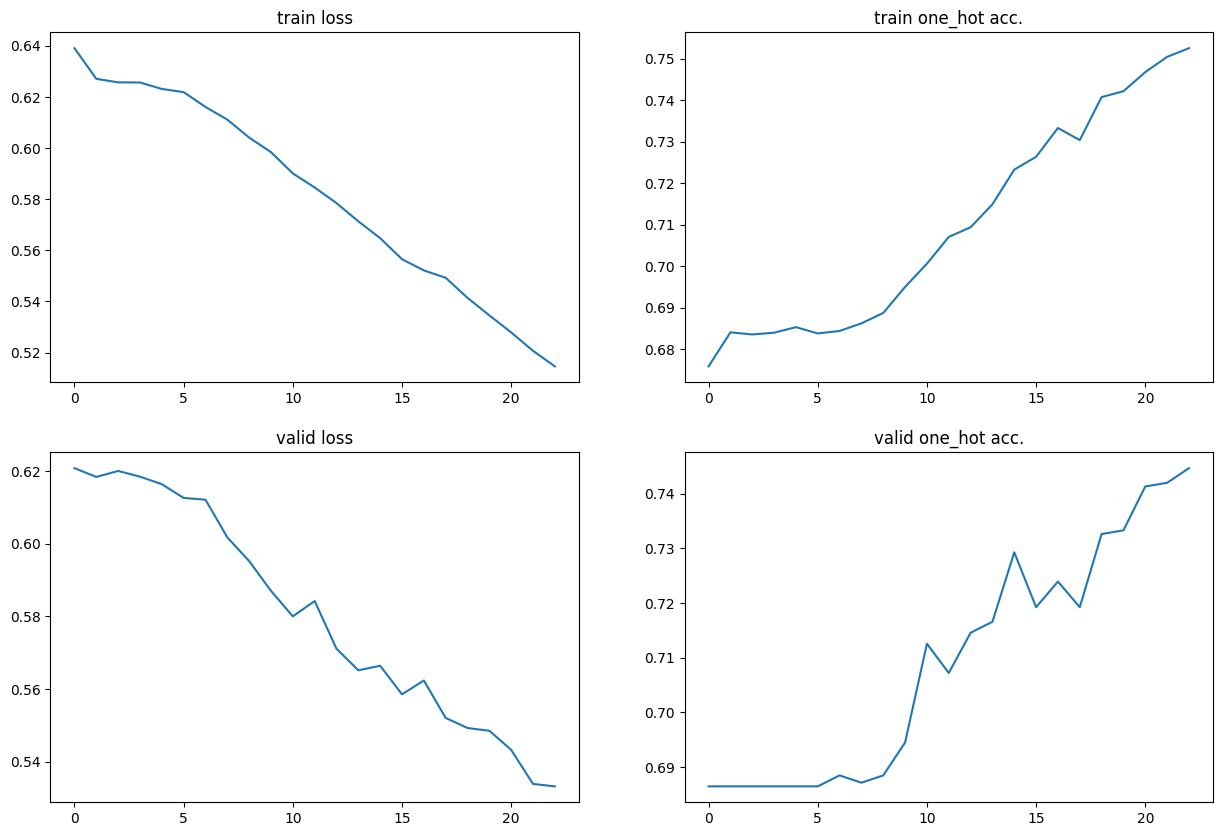

In [19]:
from tqdm import tqdm

epoch_num = 23
train_one_hot_accs = []
train_losses = []
valid_one_hot_accs = []
valid_losses = []

fig, axs = plt.subplots(2, 2, figsize=(15,10))
# https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

for epoch in tqdm(range(epoch_num)):

  train_loss, train_complete_acc = train_one_epoch(classifier, optimizer, train_dataloader)

  valid_loss, val_complete_acc = validate(classifier, val_dataloader)

  print(f"train loss: {train_loss:.2f}, valid loss: {valid_loss:.2f}")
  print(f"complete_acc: {train_complete_acc:.2f}, val_complete_acc: {val_complete_acc:.2f}")

  train_losses.append(train_loss)
  train_one_hot_accs.append(train_complete_acc)

  valid_losses.append(valid_loss)
  valid_one_hot_accs.append(val_complete_acc)

axs[0,0].set_title("train loss")
axs[0,0].plot(train_losses)
axs[0,1].set_title("train one_hot acc.")
axs[0,1].plot(train_one_hot_accs)


axs[1,0].set_title("valid loss")
axs[1,0].plot(valid_losses)
axs[1,1].set_title("valid one_hot acc.")
axs[1,1].plot(valid_one_hot_accs)
